# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple direct marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

**Data Overview**: In the 17 telephone marketing campaigns that took place between May 2008 - November 2010, 79354 contacts were made with the objective of subscribing clients to a bank term deposit. Clients were offered a long-term deposit with interest, and a success rate of 0.08 was observed in the entire database. 

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [126]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearnex import patch_sklearn 
patch_sklearn()
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
sns.set_palette("rocket")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [127]:
pd.set_option("display.max_columns", None)
bank_df = pd.read_csv('/Users/lois/Downloads/ML ipynb/Module 17/data/bank-additional-full.csv', sep = ';')
print(bank_df.shape)
bank_df.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```




#### Checking for missing values
There are no null values

In [5]:
bank_df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

#### Checking Datatypes
There are several categorical variables that will have to be encoded into numeric form. They are "job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", and "poutcome".

In [6]:
bank_df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

**Business Objective**: The business objective is to effectively predict whether an individual will subscribe to a term deposit or not, in order that marketing resources can be better distributed amongst and targeted towards clients more likely to subscribe. 

**Data Problem**: The data task is to fit and tune multiple classification models that group individuals into subscribers vs non-subscribers. Models with high accuracy and/or recall can be used to predict the subscription status of unseen clients. Additionally, fitting regression model(s) that can be further scrutinzed for the most important features and feature values that characterize each of the two groups will indicate the profile of a subscribing client. These features will used for selecting the clients on whom resources should be focused.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

#### Encoding Ordinal and Binary Columns  into Numeric Format 

In [128]:
#encoding education column
bank_df["education"].replace({"unknown" : 0, "illiterate" : 1, "high.school" : 2, "university.degree" : 3,
                         "basic.4y" : 4, "basic.6y" : 5, "basic.9y" : 6, "professional.course" : 7}, inplace = True)

#renaming y column (target variable) and changing it to numeric 
bank_df.rename({"y" : "subscribed"}, axis = 1, inplace = True)
bank_df["subscribed"].replace({"no" : 0, "yes" : 1}, inplace = True)

#### Target Encoding Nominal Columns

In [129]:
#creating a df with encoded columns
te = TargetEncoder()
encoded_df = te.fit_transform(bank_df[["job", "marital", "default", "housing", "loan"]], bank_df["subscribed"])

In [130]:
#combining encoded and original df 
bank_df.drop(["job", "marital", "default", "housing", "loan"], axis = 1, inplace = True)
bank_df = pd.concat([bank_df, encoded_df], axis = 1)
bank_df.shape

(41188, 21)

#### Correlation Analysis
The columns most positively correlated with "subscribed" are "duration", "previous", "job".

The columns most negatively correlated with "subscribed" are "pdays", "emp.var.rate", "euribor3m", "nr.employed".

There are multiple instances of high multicollinearity (0.5 or greater): 
- pdays and previous
- previous and nr.employed
- emp.var.rate and cons.price.idx
- emp.var.rate and euribor3m
- emp.var.rate and nr.employed 
- cons.price.idx and euribor3m
- cons.price.idx and nr.employed
- euribor3m and nr.employed 

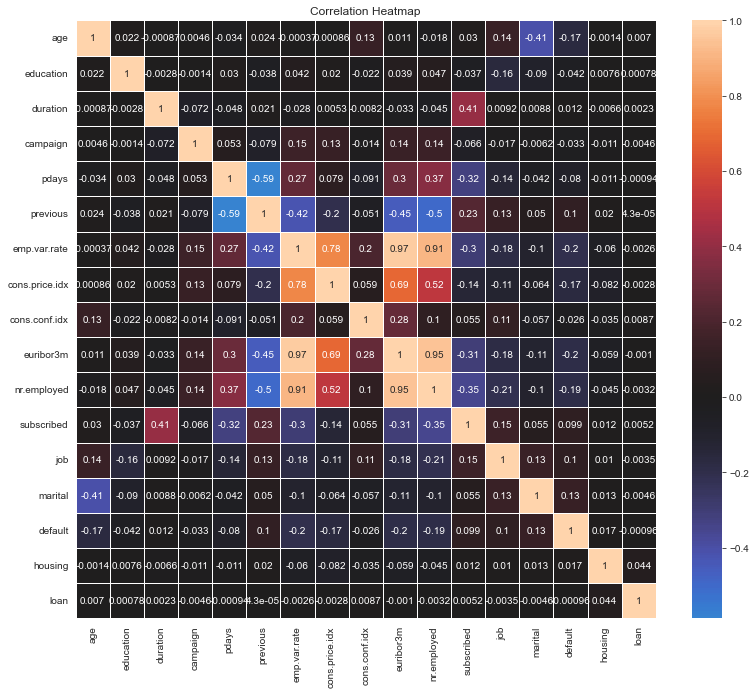

In [6]:
#correlation heatmap  
sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(13, 11))

sns.heatmap(bank_df.corr(), center = 0, linewidth = .5, annot = True).set(title='Correlation Heatmap');

### Creating the final dataframe
SequentialFeatureSelection is used to select the top 7 features from the customer data for training models. Duration (of the call) will not be considered because this information is not available before the call. Since this is a prediction task, it would not make sense to train models on data that will not be available at the time of its use. 

The estimator chosen is Logistic Regression and 5-fold cross validation is implemented. The chosen scoring metric is accuracy, because we want our predictive model to maximize the number of correct predictions. 

The top 7 features are campaign, pdays, nr.employed, marital, default, housing, and loan. These features do not exhibit multicollinearity with each other and will constitute the final df. 

In [131]:
#subsetting the dataframe to numeric values
df_num = bank_df.drop(["contact", "month", "day_of_week", "poutcome"], axis = 1)

In [132]:
X = df_num.drop(["subscribed", "duration"], axis = 1)
y = df_num["subscribed"]

In [21]:
#SequentialFeatureSelection
sfs = SequentialFeatureSelector(estimator = LogisticRegression(),
                               scoring = "accuracy",
                               cv = 5,
                               n_features_to_select = 7)

sfs.fit(X, y)

SequentialFeatureSelector(estimator=LogisticRegression(),
                          n_features_to_select=7, scoring='accuracy')

In [22]:
#getting results
sfs.get_feature_names_out(input_features=None)

array(['campaign', 'pdays', 'nr.employed', 'marital', 'default',
       'housing', 'loan'], dtype=object)

In [133]:
#constructing final df
df = bank_df[['campaign', 'pdays', 'nr.employed', 'marital', 'default',
       'housing', 'loan', 'subscribed']]

#### Visualizing the Distribution of "subscribed" 
This is an imbalanced dataset, with the vast majority of people rejecting the subscription offer.

Text(0.5, 1.0, 'Subscription Counts')

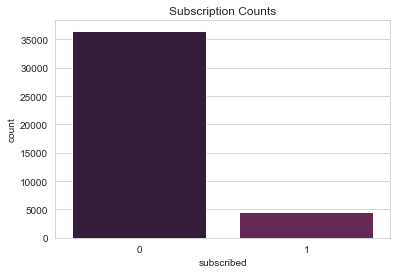

In [15]:
sns.countplot(data = df, x = df["subscribed"]).set_title("Subscription Counts")

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [134]:
X = df.drop("subscribed", axis = 1)
y = df["subscribed"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

The baseline accuracy for a model that predicts the majority for all data points is **0.888**

In [135]:
#baseline score for the model that predicts the majority class for all data points
y_test.value_counts(normalize = True)[0]

0.8875940762320952

### Problem 8: A Simple Model

Logistic Regression is implemented with holdout cross validation to build a basic model on the data.  

In [136]:
#fitting logistic regression model 
logreg = LogisticRegression()
start = time.time()
logreg.fit(X_train, y_train)
stop = time.time()
log_time = stop - start

In [137]:
logreg_train_preds = logreg.predict(X_train)
logreg_test_preds = logreg.predict(X_test)
logreg_train_acc = accuracy_score(logreg_train_preds, y_train)
logreg_test_acc = accuracy_score(logreg_test_preds, y_test)

### Problem 9: Score the Model

The accuracy of the Logistic Regression model is **0.897**.

In [138]:
print(f"Logistic Regression Accuracy Score: {np.round(logreg_test_acc, 3)}")

Logistic Regression Accuracy Score: 0.897


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

The performance metric used for these four models is accuracy score. Because the business objective is to accurately group clients into subscribers vs nonsubscribers, accuracy is an appropriate metric if we want to maximize the number of correct predictions. Holdout cross validation is implemented for each of these models.

#### KNN Model

In [139]:
#training the knn model 
knn = KNeighborsClassifier()
start = time.time()
knn.fit(X_train, y_train)
stop = time.time()
knn_time = stop - start

In [140]:
knn_train_preds = knn.predict(X_train)
knn_test_preds = knn.predict(X_test)
knn_train_acc = accuracy_score(knn_train_preds, y_train)
knn_test_acc = accuracy_score(knn_test_preds, y_test)

#### Decision Tree Model 

In [141]:
dtree = DecisionTreeClassifier()
start = time.time()
dtree.fit(X_train, y_train)
stop = time.time()
dtree_time = stop - start

In [142]:
tree_train_preds = dtree.predict(X_train)
tree_test_preds = dtree.predict(X_test)
tree_train_acc = accuracy_score(tree_train_preds, y_train)
tree_test_acc = accuracy_score(tree_test_preds, y_test)

#### SVM Model

In [143]:
svc = SVC()
start = time.time()
svc.fit(X_train, y_train)
stop = time.time()
svc_time = stop - start

In [144]:
svc_train_preds = svc.predict(X_train)
svc_test_preds = svc.predict(X_test)
svc_train_acc = accuracy_score(svc_train_preds, y_train)
svc_test_acc = accuracy_score(svc_test_preds, y_test)

#### Building Results Table
Every model outperformed the baseline accuracy 0.888.

In [145]:
data = {"Model" : ["Logistic Regression", "KNN", "Decision Tree", "SVC"],
        "Train Time (sec)" : [log_time, knn_time, dtree_time, svc_time],
        "Train Accuracy" : [logreg_train_acc, knn_train_acc, tree_train_acc, svc_train_acc],
        "Test Accuracy" : [logreg_test_acc, knn_test_acc, tree_test_acc, svc_test_acc]}

In [146]:
results_df = pd.DataFrame(data).set_index("Model")
results_df

,Train Time (sec),Train Accuracy,Test Accuracy
Model,,,
Logistic Regression,0.017714,0.898130,0.897143
KNN,0.023802,0.897055,0.891640
Decision Tree,0.027343,0.912004,0.893502
SVC,1.022523,0.897818,0.896820


#### Comparing Confusion Matrices
Confusion matrices indicate the counts of the type of error each model made in the classification task. In these plots, 0 = not subscribed and 1 = subscribed. All four models exhibit an overwhelming number of false negatives, much higher than the number of false positives, which makes sense since the majority class is "not subscribed". However, this indicates that the classifiers predicted "not subscribed" for many clients that did subscribe. The high number of false negatives does not align with the business objective of identifying as many subscribing clients as possible. It is additionally worth noting that the accuracy metric is not suited for imbalanced datasets.  

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

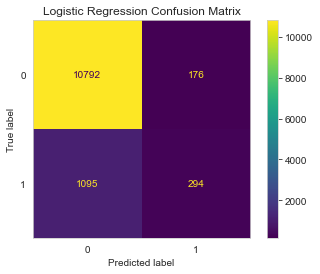

In [147]:
ConfusionMatrixDisplay(confusion_matrix(y_test, logreg_test_preds)).plot()
plt.grid(False)
plt.title("Logistic Regression Confusion Matrix")

Text(0.5, 1.0, 'KNN Confusion Matrix')

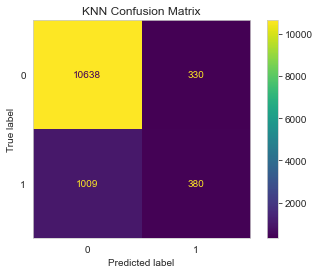

In [148]:
ConfusionMatrixDisplay(confusion_matrix(y_test, knn_test_preds)).plot()
plt.grid(False)
plt.title("KNN Confusion Matrix")

Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

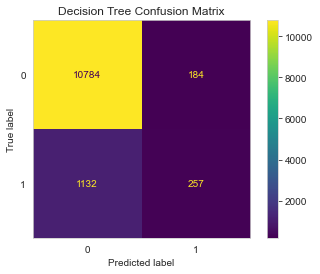

In [149]:
ConfusionMatrixDisplay(confusion_matrix(y_test, tree_test_preds)).plot()
plt.grid(False)
plt.title("Decision Tree Confusion Matrix")

Text(0.5, 1.0, 'SVC Confusion Matrix')

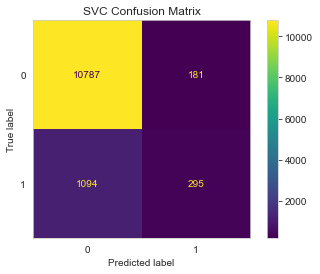

In [150]:
ConfusionMatrixDisplay(confusion_matrix(y_test, svc_test_preds)).plot()
plt.grid(False)
plt.title("SVC Confusion Matrix")

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Checking Distribution / Skew of Features
The features of the original full dataframe checked for skewness.

In [42]:
#checking skew
pd.DataFrame(bank_df.skew()).rename({0 : "Skew"}, axis = 1)

,Skew
age,0.784697
education,0.283121
duration,3.263141
campaign,4.762507
pdays,-4.922190
previous,3.832042
emp.var.rate,-0.724096
cons.price.idx,-0.230888
cons.conf.idx,0.303180
euribor3m,-0.709188


#### Log Transforming Columns with Skew of 3 or above

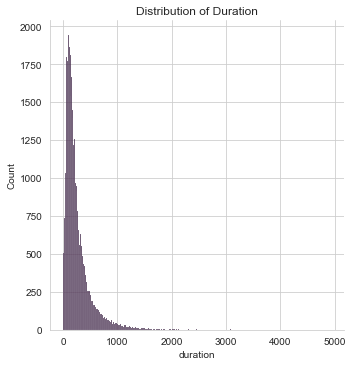

In [43]:
#checking distribution of duration
sns.displot(bank_df["duration"]).set(title = "Distribution of Duration")

[Text(0.5, 1.0, 'Log-Transformed Distribution of Duration')]

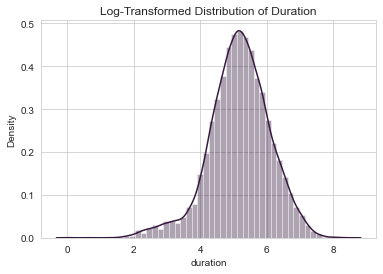

In [151]:
#log-transforming duration column
bank_df["duration"] = np.log1p(bank_df["duration"])
sns.distplot(bank_df['duration']).set(title = "Log-Transformed Distribution of Duration")

[Text(0.5, 1.0, 'Distribution of Campaign')]

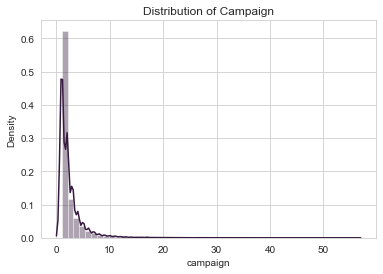

In [45]:
#checking distribution of campaign
sns.distplot(bank_df['campaign']).set(title = "Distribution of Campaign")

[Text(0.5, 1.0, 'Log-Transformed Distribution of Campaign')]

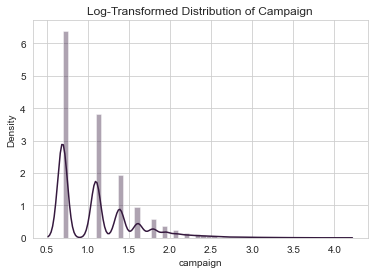

In [152]:
#log-transforming campaign
bank_df["campaign"] = np.log1p(bank_df["campaign"])
sns.distplot(bank_df['campaign']).set(title = "Log-Transformed Distribution of Campaign")

[Text(0.5, 1.0, 'Distribution of Pdays')]

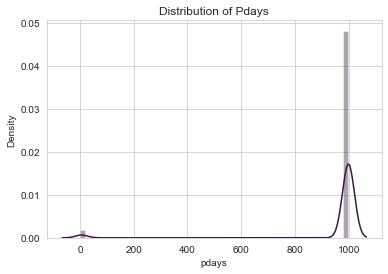

In [47]:
#checking distribution of pdays
sns.distplot(bank_df['pdays']).set(title = "Distribution of Pdays")

I will not be log-transforming the distribution of pdays because the value 999 means the client was not previously contacted, which means a high value no numeric significance. 

[Text(0.5, 1.0, 'Distribution of Previous')]

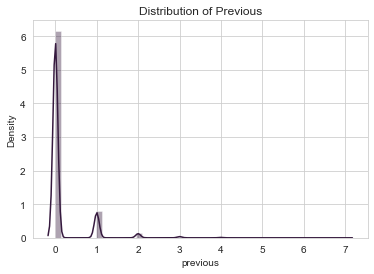

In [153]:
#checking distribution of previous
sns.distplot(bank_df['previous']).set(title = "Distribution of Previous")

[Text(0.5, 1.0, 'Log-Transformed Distribution of Previous')]

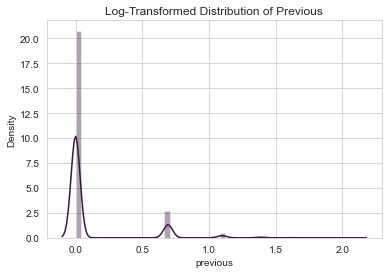

In [154]:
#log-transforming previous 
bank_df["previous"] = np.log1p(bank_df["previous"])
sns.distplot(bank_df['previous']).set(title = "Log-Transformed Distribution of Previous")

In [155]:
bank_df.skew()

age               0.784697
education         0.283121
duration         -0.421327
campaign          1.350403
pdays            -4.922190
previous          2.587040
emp.var.rate     -0.724096
cons.price.idx   -0.230888
cons.conf.idx     0.303180
euribor3m        -0.709188
nr.employed      -1.044262
subscribed        2.450330
job               2.372102
marital           0.964322
default          -1.433478
housing          -0.098167
loan             -1.757183
dtype: float64

#### SequentialFeatureSelection of Log-Transformed Columns
The selected columns are education, pdays, cons.price.idx, euribor3m, marital, housing, and loan. 

In [206]:
#selecting and splitting the data
df_num = bank_df.drop(["contact", "month", "day_of_week", "poutcome", "duration"], axis = 1)
X = df_num.drop("subscribed", axis = 1)
y = df_num["subscribed"]

In [207]:
#SequentialFeatureSelection
sfs = SequentialFeatureSelector(estimator = LogisticRegression(),
                               scoring = "recall",
                               cv = 5,
                               n_features_to_select = 7)

sfs.fit(X, y)

SequentialFeatureSelector(estimator=LogisticRegression(),
                          n_features_to_select=7, scoring='recall')

In [208]:
#getting results
sfs.get_feature_names_out(input_features=None)

array(['education', 'pdays', 'cons.price.idx', 'euribor3m', 'marital',
       'housing', 'loan'], dtype=object)

In [213]:
#constructing final df
final_df = bank_df[['education', 'pdays', 'cons.price.idx', 'euribor3m', 'marital',
       'housing', 'loan', 'subscribed']]

In [217]:
#splitting the data
X = final_df.drop("subscribed", axis = 1)
y = final_df["subscribed"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#### Checking for Multicollinearity
Consumer price index (cons.price.idx) is moderately negatively correlated with the euribor 3-month rate (euribor3m). This will be accounted for by implementing 5-fold cross validation in the upcoming models.

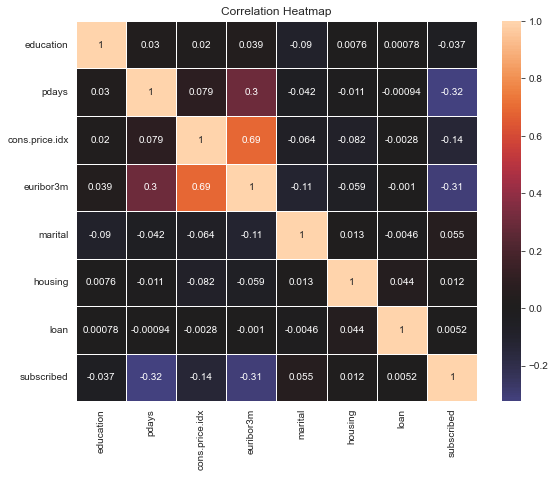

In [214]:
sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(9, 7))

sns.heatmap(df.corr(), center = 0, linewidth = .5, annot = True).set(title='Correlation Heatmap');

#### Performance Metric Rationale 

The business objective is to identify clients that will subscribe, so we are prioritizing the correct classification of subscribers, rather than of unsubscribers. The original performance metric was **accuracy** because we wanted to maximize the number of correct predictions. This is not ideal for imbalanced datasets, which is the case for the bank subscriptions data. The alternative we will try here is **recall**, since our priority is to correctly identify as many subscribers (true positive) as possible, even at the cost of misclassifying a few non-subscribers as subscribers (false positive). 

#### RandomizedSearchCV for the four models
Unlike the previous instances of model fitting, which implemented holdout cross validation, stratified 5-fold cross validation will be used for training these models. Hence, the models will be fitted on X and y, rather than X_train and y_train. We will be using the new log-transformed dataframe with the top 7 features selected by SequentialFeatureSelector. RandomizedSearchCV will be used to iterate through a dictionary of possible values for a subset of each model's hyperparameters to find the optimal hyperparameter values for each model. We will be using the performance metric of recall.

##### Logistic Regression
The best parameters for Logistic regression are l2 penalty, multinomial multiclass, and C = 10.

In [218]:
#parameters for RandomizedSearchCV 
log_params = {"penalty" : ["l1", "l2"], "C": [0.001,0.01,0.1,1,10,100,1000], "multi_class" : ["ovr", "multinomial"]}

In [219]:
rand_log = RandomizedSearchCV(estimator = LogisticRegression(),
                          param_distributions = log_params,
                          scoring = "recall",
                          cv = 5) 

rand_log.fit(X, y)
n_iter = pd.DataFrame(rand_log.cv_results_).shape[0] 
rand_log_time = np.mean(rand_log.cv_results_["mean_fit_time"] + rand_log.cv_results_["mean_score_time"]) * rand_log.n_splits_ * n_iter
rand_log_score = rand_log.best_score_

print(f"best params: {rand_log.best_params_}")

best params: {'penalty': 'l2', 'multi_class': 'multinomial', 'C': 10}


##### KNN
The optimal number of neighbors for KNN is 3.

In [221]:
knn_params = {"n_neighbors" : np.array(range(1, 10))}

In [222]:
rand_knn = RandomizedSearchCV(estimator = KNeighborsClassifier(),
                          param_distributions = knn_params,
                          scoring = "recall",
                          cv = 5) 

rand_knn.fit(X, y)
n_iter = pd.DataFrame(rand_knn.cv_results_).shape[0] 
rand_knn_time = np.mean(rand_knn.cv_results_["mean_fit_time"] + rand_knn.cv_results_["mean_score_time"]) * rand_knn.n_splits_ * n_iter
rand_knn_score = rand_knn.best_score_

print(f"best params: {rand_knn.best_params_}")

best params: {'n_neighbors': 3}


##### Decision Tree
The best Decision Tree model has a min sample split of 5, min samples leaf of 3, max depth of 4, and uses the gini criterion.

In [223]:
tree_params = {"criterion" : ["gini", "entropy", "log_loss"],
               "max_depth" : np.array(range(1, 6)),
               "min_samples_split" : np.array(range(1, 6)),
               "min_samples_leaf" : np.array(range(1, 6))}

In [224]:
rand_tree = RandomizedSearchCV(estimator = DecisionTreeClassifier(),
                          param_distributions = tree_params,
                          scoring = "recall",
                          cv = 5) 

rand_tree.fit(X, y)
n_iter = pd.DataFrame(rand_tree.cv_results_).shape[0] 
rand_tree_time = np.mean(rand_tree.cv_results_["mean_fit_time"] + rand_tree.cv_results_["mean_score_time"]) * rand_tree.n_splits_ * n_iter
rand_tree_score = rand_tree.best_score_

print(f"best params: {rand_tree.best_params_}")

best params: {'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 4, 'criterion': 'gini'}


##### SVC
The best rbf kernel SVC model is of degree 5, and C = 1. 

In [225]:
svc_params = {"C" : [0.001,0.01,0.1,1,10,100,1000],
              "kernel" : ["rbf"],
              "degree" : np.array(range(1, 6))}

In [226]:
rand_svc = RandomizedSearchCV(estimator = SVC(),
                          param_distributions = svc_params,
                          scoring = "recall",
                          cv = 5) 

rand_svc.fit(X, y)
n_iter = pd.DataFrame(rand_svc.cv_results_).shape[0] 
rand_svc_time = np.mean(rand_svc.cv_results_["mean_fit_time"] + rand_svc.cv_results_["mean_score_time"]) * rand_svc.n_splits_ * n_iter
rand_svc_score = rand_svc.best_score_

print(f"best params: {rand_svc.best_params_}")

best params: {'kernel': 'rbf', 'degree': 5, 'C': 1}


#### Comparing the two sets of classification models
The first set of models had high accuracy scores but a high false negative count. As a result, we changed the performance metric to recall, which is used when one wants to maximize the number of correctly-predicted positives (true positives) and minimize the number of incorrectly-predicted negatives (false negatives). Recall is calculated by dividing the number of true positive predictions by the actual number of positives, or **True Positive / (True Positive + False Negative)**. Minimizing false negative count makes it such that we will not miss as many subscribers, which is important because the entire database had a success rate of 0.08. Of the four models, **Logistic Regression has the highest recall score of 0.27, which means it has the lowest number of false negatives**. 

In [227]:
rand_data = {"Model" : ["Logistic Regression", "KNN", "Decision Tree", "SVC"],
        "Train Time (sec)" : [rand_log_time, rand_knn_time, rand_tree_time, rand_svc_time],
        "Best Recall" : [rand_log_score, rand_knn_score, rand_tree_score, rand_svc_score]}

In [228]:
rand_results_df = pd.DataFrame(rand_data).set_index("Model")
rand_results_df

,Train Time (sec),Best Recall
Model,,
Logistic Regression,0.847137,0.279526
KNN,14.675919,0.222629
Decision Tree,0.728621,0.214440
SVC,55.912103,0.208405


### Comparing Regression Models 
RandomizedSearchCV is used to fit logistic, ridge, and lasso regression models with stratified 5-fold cross validation. These will be scored by negative mean squared error because they are regression models that predict the binary value of the subscribed column. The MSE gauges the quality of a model by comparing the predicted values with the actual values from the dataset. The best model has the lowest sum of squared difference between the predicted and actual values. Additionally, neg_mean_squared_error is used in RandomizedSearchCV it maximises the score.

#### Logistic Regression
The best parameters l2 penalty, multi_class = ovr, and C = 0.001.

In [229]:
#parameters for RandomizedSearchCV 
log_params = {"penalty" : ["l1", "l2"], "C": [0.001,0.01,0.1,1,10,100,1000], "multi_class" : ["ovr", "multinomial"]}

In [230]:
rand_log_reg = RandomizedSearchCV(estimator = LogisticRegression(),
                          param_distributions = log_params,
                          scoring = "neg_mean_squared_error",
                          cv = 5) 

rand_log_reg.fit(X, y)
n_iter = pd.DataFrame(rand_log_reg.cv_results_).shape[0] 
rand_log_reg_time = np.mean(rand_log_reg.cv_results_["mean_fit_time"] + rand_log_reg.cv_results_["mean_score_time"]) * rand_log_reg.n_splits_ * n_iter
rand_log_reg_score = rand_log_reg.best_score_

print(f"best params: {rand_log_reg.best_params_}")

best params: {'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.001}


#### Ridge Regression 
The best ridge model has alpha = 0.0001.

In [232]:
ridge_alphas = {"ridge__alpha" : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [233]:
#building an unfit ridge model
ridge_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("ridge", Ridge())
])

In [234]:
rand_ridge = RandomizedSearchCV(estimator = ridge_pipe,
                            param_distributions = ridge_alphas,
                            scoring = "neg_mean_squared_error",
                            cv = 5)   
rand_ridge.fit(X, y)
n_iter = pd.DataFrame(rand_ridge.cv_results_).shape[0] 
rand_ridge_time = np.mean(rand_ridge.cv_results_["mean_fit_time"] + rand_ridge.cv_results_["mean_score_time"]) * rand_ridge.n_splits_ * n_iter
rand_ridge_score = rand_ridge.best_score_

print(f"best params: {rand_ridge.best_params_}")

best params: {'ridge__alpha': 0.0001}


#### Lasso Regression
The best lasso model has alpha = 0.0001.

In [236]:
lasso_alphas = {"lasso__alpha" : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [237]:
#building a an unfit lasso model 
lasso_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("lasso", Lasso())
])

In [238]:
rand_lasso = RandomizedSearchCV(estimator = lasso_pipe,
                            param_distributions = lasso_alphas,
                            scoring = "neg_mean_squared_error",
                            cv = 5)   
rand_lasso.fit(X, y)
n_iter = pd.DataFrame(rand_lasso.cv_results_).shape[0] 
rand_lasso_time = np.mean(rand_lasso.cv_results_["mean_fit_time"] + rand_lasso.cv_results_["mean_score_time"]) * rand_lasso.n_splits_ * n_iter
rand_lasso_score = rand_lasso.best_score_

print(f"best params: {rand_lasso.best_params_}")

best params: {'lasso__alpha': 0.0001}


#### Results 
Ridge Regression outperformed Lasso and Logistic Regression, having lowest mean sqaured error. We will be further analyzing these model to identify the features that contributed most to the prediction task.

In [239]:
rand_data = {"Model" : ["Logistic Regression", "Lasso Regression", "Ridge Regression"],
        "Train Time (sec)" : [rand_log_reg_time, rand_lasso_time, rand_ridge_time],
        "MSE" : [(-1 * rand_log_reg_score), (-1 * rand_lasso_score), (-1 * rand_ridge_score)]}

In [240]:
rand_results_df = pd.DataFrame(rand_data).set_index("Model")
rand_results_df

,Train Time (sec),MSE
Model,,
Logistic Regression,0.684850,0.102311
Lasso Regression,0.456625,0.089740
Ridge Regression,0.403524,0.089721


#### Permutation Importance 
The results of applying Permutation Importance to the three models reveal that the features that contributed most to the model's prediction of subscription status are pdays, euribor3m, cons.price.idx, education, marital, and loan. 
##### Logistic Regression Importances

In [241]:
log_importance = permutation_importance(rand_log_reg, X_test, y_test, n_repeats = 50, random_state = 42)

In [242]:
for i in log_importance.importances_mean.argsort()[::-1]:
    if log_importance.importances_mean[i] - 2 * log_importance.importances_std[i] > 0:
        print(f"{X.columns[i] : <8}:"
             f"{log_importance.importances_mean[i] : .3f}"
             f"+/- {log_importance.importances_std[i] : .3f}")

pdays   : 0.017+/-  0.001
euribor3m: 0.007+/-  0.001


##### Lasso Regression Importances

In [243]:
lasso_importance = permutation_importance(rand_lasso, X_test, y_test, n_repeats = 50, random_state = 42)

In [244]:
for i in lasso_importance.importances_mean.argsort()[::-1]:
    if lasso_importance.importances_mean[i] - 2 * lasso_importance.importances_std[i] > 0:
        print(f"{X.columns[i] : <8}:"
             f"{lasso_importance.importances_mean[i] : .3f}"
             f"+/- {lasso_importance.importances_std[i] : .3f}")

euribor3m: 0.016+/-  0.000
pdays   : 0.012+/-  0.000
cons.price.idx: 0.002+/-  0.000
education: 0.000+/-  0.000
marital : 0.000+/-  0.000
loan    : 0.000+/-  0.000


##### Ridge Regression Importances

In [245]:
ridge_importance = permutation_importance(rand_ridge, X_test, y_test, n_repeats = 50, random_state = 42)

In [246]:
for i in ridge_importance.importances_mean.argsort()[::-1]:
    if ridge_importance.importances_mean[i] - 2 * ridge_importance.importances_std[i] > 0:
        print(f"{X.columns[i] : <8}:"
             f"{ridge_importance.importances_mean[i] : .3f}"
             f"+/- {ridge_importance.importances_std[i] : .3f}")

euribor3m: 0.017+/-  0.000
pdays   : 0.012+/-  0.000
cons.price.idx: 0.002+/-  0.000
education: 0.000+/-  0.000
marital : 0.000+/-  0.000
loan    : 0.000+/-  0.000


##### Top 6 features' correlation with subscribed
This heatmap shows that loan and marital are positively correlated with subscribed, while the rest of the features exhibit negative correlation with subscription status. We will further analyze the features pdays, education, marital, and loan, since consumer price index and the euribor 3 month rate are not variables one can control. I will additionally be examining number employed feature, as it exhibits a higher correlation with subscription, as seen in the earlier heatmaps. 

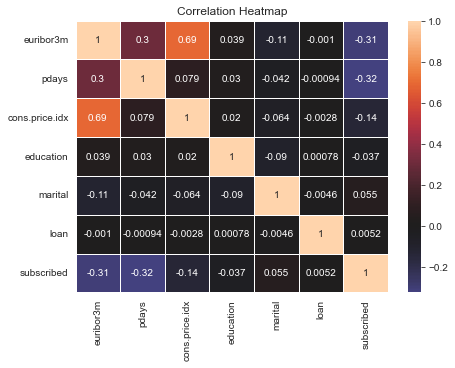

In [258]:
sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(7, 5))

top_6 = final_df[["euribor3m", "pdays", "cons.price.idx", "education", "marital", "loan", "subscribed"]]
sns.heatmap(top_6.corr(), center = 0, linewidth = .5, annot = True).set(title='Correlation Heatmap');

##### Note: This analysis is continued in PAA_III_Evaluation which further breaks down the five features.